# Memory


### Long-Term Memory (LTM)


- The library of an LLM. It’s the vast, curated collection of data, storing everything from text to conceptual frameworks.

Applications include:

1. Vector databases

- These databases can store unstructured text data, providing the model with a
  reference point when generating content. By indexing and categorizing this data,
  LLMs can swiftly retrieve relevant information via similarity distance metrics.

2. Self-reflection

- Advanced applications include an LLM that introspects, records, and stores
  thoughts. Imagine an LLM that meticulously observes user patterns on a book
  review platform and catalogs these as deep insights. Over time, it pinpoints
  preferences, such as favored genres and writing styles. These insights are stored
  and accessed using retrieval. When users seek book recommendations, the LLM,
  powered by the retrieved context, provides bespoke suggestions aligned with their
  tastes.

3. Custom retrievers

- Creating specific retrieval functions can significantly boost an LLM’s efficiency.
  Drawing parallels with human memory systems, these functions can prioritize
  data based on its relevance, the elapsed time since the last memory, and its utility
  in achieving a particular objective.


### Short-Term Memory (STM)


- temporary workspace. Here, recent interactions, active tasks, or ongoing conversations are kept at the forefront to ensure continuity and context

Applications include:

1. Conversational histories

- For chatbots, tracking conversational history is essential. It allows the bot to
  maintain context over multiple exchanges, preventing redundant queries and
  ensuring the conversation flows naturally

2. Repetition avoidance

- STM proves invaluable when similar or identical queries are posed by users. By
  referencing its short-term recall, the model can provide consistent answers or
  diversify its responses, based on the application’s requirement.


### Short-Term Memory in QA Conversation Agents


Imagine Eva, a virtual customer support agent for an e-commerce platform. A user
might have several interlinked queries:

User: “How long is the return policy for electronics?”

Eva: “The return policy for electronics is 30 days.”

User: “What about for clothing items?”

Eva, leveraging STM: “For clothing items, it’s 45 days. Would you like to know
about any other categories?”

Notice that by utilizing short term memory (STM), Eva seamlessly continues the
conversation, anticipating potential follow-up questions. This fluidity is only possible due to the effective deployment of short-term memory, allowing the agent to perceive conversations not as isolated QAs but as a cohesive interaction.


# Memory in LangChain


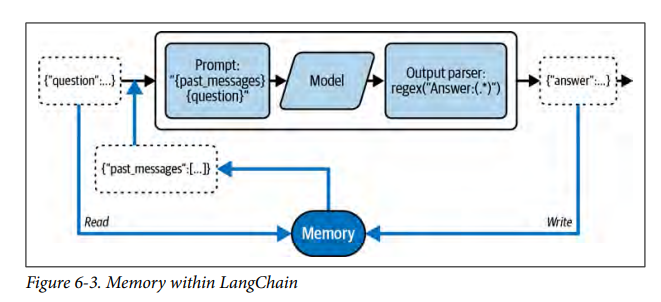


Process:

1. After collecting the initial user data but before executing, the chain retrieves information from its memory, adding to the user’s input.
2. After the chain has completed but before returning the answer, a chain will write
   the inputs and outputs of the current run to memory so that they can be referred
   to in future runs.


## Preserving the State


- the foundational memory of generative AI models is structured as a sequence of chat messages.
- These messages can be stored in temporary in-memory lists or anchored in a more durable database.
- there’s a wide range of [database integrations](https://python.langchain.com/v0.2/docs/integrations/memory/) available, streamlining the process and saving you from the hassle of manual integration.


In [3]:
from langchain_mongodb.chat_message_histories import MongoDBChatMessageHistory

# Provide the connection string to connect to the MongoDB database.
connection_string = "mongodb://localhost:27017"

chat_message_history = MongoDBChatMessageHistory(
    session_id="test_session",
    connection_string=connection_string,
    database_name="my_db",
    collection_name="chat_histories",
)

chat_message_history.add_user_message("I love programming!!")
chat_message_history.add_ai_message("What do you like about it?")
chat_message_history.messages

[HumanMessage(content='I love programming!!'),
 AIMessage(content='What do you like about it?')]

Reference: 01_LangChain_for_LLM_Application_Development/L2-Memory.ipynb


### ConversationBufferMemory


In [4]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory()
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': 'Human: hi\nAI: whats up'}

In [5]:
memory = ConversationBufferMemory(return_messages=True)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': [HumanMessage(content='hi'), AIMessage(content='whats up')]}

In [6]:
# Using within a chain:
from langchain.memory import ConversationBufferMemory
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from operator import itemgetter

memory = ConversationBufferMemory(return_messages=True)

model = ChatOpenAI(temperature=0)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Act as a chatbot that helps users with their queries."),
        # The history of the conversation
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

chain = (
    {
        "input": lambda x: x["input"],
        "history": RunnableLambda(memory.load_memory_variables) |
        itemgetter("history"),
    }
    | prompt
    | model
    | StrOutputParser()
)

In [8]:
inputs = {"input": "Hi my name is Fu Lim!"}
result = chain.invoke(inputs)
memory.save_context(inputs, {"outputs": result})
print(memory.load_memory_variables({}))

{'history': [HumanMessage(content='Hi my name is James!'), AIMessage(content='Hello James! How can I assist you today?'), HumanMessage(content='Hi my name is Fu Lim!'), AIMessage(content='Hello Fu Lim! How can I assist you today?')]}


In [9]:
inputs = {"input": "What is my name?"}
second_result = chain.invoke(inputs)
print(second_result)

Your name is Fu Lim. How can I assist you today, Fu Lim?


#### Example


In [45]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.tools import tool
from langchain_openai.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory

# 1. Create the model and memory:
model = ChatOpenAI(model="gpt-4o", temperature=0)
memory = ConversationBufferMemory(return_messages=True)


@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)


# 2. Create the tools:
tools = [get_word_length]

In [46]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# 3. Create the Prompt:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are very powerful assistant, but don't know current events and isn't good at calculating word length.",
        ),
        # This is where the agent will write/read its messages from
        MessagesPlaceholder(variable_name="agent_scratchpad"),
        MessagesPlaceholder(variable_name="history"),
        ("user", "{input}"),
    ]
)

In [47]:
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.runnables import RunnableLambda
from operator import itemgetter

# 4. Formats the python function tools into JSON schema and binds them to the model:
llm_with_tools = model.bind_tools(
    tools=[convert_to_openai_tool(t) for t in tools])


# 5. Setting up the agent chain:
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
        "history": RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [49]:
# Construct the OpenAI functions agent:
agent = create_openai_tools_agent(llm_with_tools, tools, prompt)

In [50]:
# Create an agent executor by passing in the agent, tools and memory:
memory = ConversationBufferMemory(return_messages=True)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, memory=memory)

In [51]:
agent_executor.invoke({"input": "My name is Wong Fu Lim"})



> Entering new AgentExecutor chain...

Invoking: `get_word_length` with `{'word': 'Wong'}`


4
Invoking: `get_word_length` with `{'word': 'Fu'}`


2
Invoking: `get_word_length` with `{'word': 'Lim'}`


3Nice to meet you, Wong Fu Lim! How can I assist you today?

> Finished chain.


{'input': 'My name is Wong Fu Lim',
 'history': [HumanMessage(content='My name is Wong Fu Lim'),
  AIMessage(content='Nice to meet you, Wong Fu Lim! How can I assist you today?')],
 'output': 'Nice to meet you, Wong Fu Lim! How can I assist you today?'}

In [52]:
agent_executor.invoke(
    {"input": "What are the first three characters of my name?"})



> Entering new AgentExecutor chain...
The first three characters of your name "Wong Fu Lim" are "Won".

> Finished chain.


{'input': 'What are the first three characters of my name?',
 'history': [HumanMessage(content='My name is Wong Fu Lim'),
  AIMessage(content='Nice to meet you, Wong Fu Lim! How can I assist you today?'),
  HumanMessage(content='What are the first three characters of my name?'),
  AIMessage(content='The first three characters of your name "Wong Fu Lim" are "Won".')],
 'output': 'The first three characters of your name "Wong Fu Lim" are "Won".'}

### ConversationBufferWindowMemory


This type maintains a sliding window of the most recent interactions, ensuring the
buffer doesn’t grow excessively large. Features include the following:

- Keeps only the last K interactions
- Can return history as either a string or a list of messages


In [53]:
from langchain.memory import ConversationBufferWindowMemory
memory = ConversationBufferWindowMemory(k=1)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.save_context({"input": "not much you"}, {"output": "not much"})

memory.load_memory_variables({})

{'history': 'Human: not much you\nAI: not much'}

### ConversationSummaryMemory

This one condenses and summarizes the conversation over time and is ideal for
longer conversations where verbatim message history would be token-expensive.
Features include the following:

- Summarizes conversation on the fly
- Can return history as a summary string or a list of system messages
- Allows direct prediction of new summaries
- Can be initialized with existing messages or summaries


In [54]:
from langchain.memory import ConversationSummaryMemory, ChatMessageHistory
from langchain_openai import OpenAI
memory = ConversationSummaryMemory(llm=OpenAI(temperature=0))
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': "\nThe human greets the AI and asks what's up. The AI responds by asking what's going on."}

### ConversationSummaryBufferMemory

This is a hybrid memory that maintains a buffer of recent interactions but also
compiles older interactions into a summary.
Features include the following:

- Uses token length to determine when to flush interactions
- Can return history as a summary with recent interactions or a list of messages
- Allows direct prediction of new summaries


In [55]:
from langchain.memory import ConversationSummaryBufferMemory
from langchain_openai.chat_models import ChatOpenAI
memory = ConversationSummaryBufferMemory(llm=ChatOpenAI(), max_token_limit=10)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': 'System: The human simply greets the AI with "hi."\nAI: whats up'}

### ConversationTokenBufferMemory

This one keeps a buffer of recent interactions using token length to determine when
to flush interactions.
Features include the following:

- Uses token length for flushing
- Can return history as a string or a list of messages


In [57]:
from langchain.memory import ConversationTokenBufferMemory
from langchain_openai.chat_models import ChatOpenAI
memory = ConversationTokenBufferMemory(llm=ChatOpenAI(),
                                       max_token_limit=10)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': 'AI: whats up'}

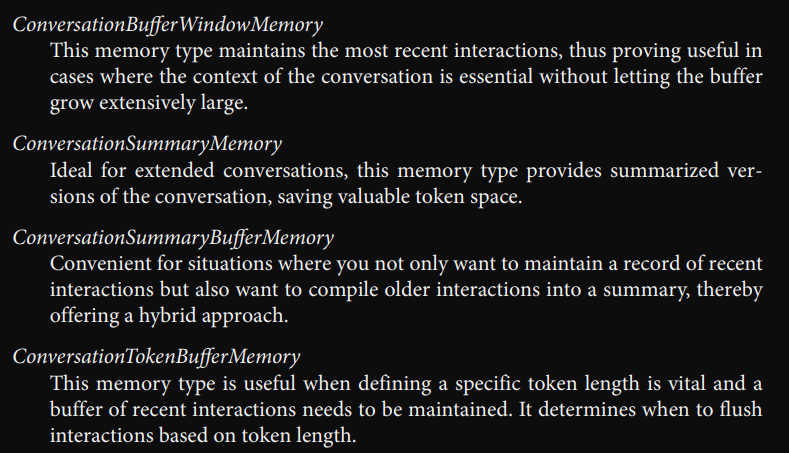


# OpenAI Functions Agent with Memory


# Custom Tools Memory Agent


In [58]:
from langchain.agents import create_openai_tools_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import SystemMessage
from langchain.tools import StructuredTool
from langchain_community.utilities.serpapi import SerpAPIWrapper
from dotenv import load_dotenv
load_dotenv()

True

In [59]:
# Define Tools:
def google_search(query: str):
    """Tool to search Google"""
    return SerpAPIWrapper().run(query)


def save_interview(raw_interview_text: str):
    """Tool to save the interview. You must pass the entire interview and conversation in here.
    The interview will then be saved to a local file. Remember to include all of the previous chat messages.
    Include all of the messages with the user and the AI, here is a good response:
    AI: some text
    Human: some text
    ...
    ---
    """
    # Save to local file:
    with open("interview.txt", "w") as f:
        f.write(raw_interview_text)
    return f"Interview saved! Content: {raw_interview_text}. File: interview.txt. You must tell the user that the interview is saved."


def get_pokemon(pokemon_name: str):
    """Tool to get a single Pokemon"""
    import requests
    clean_pokemon_name = pokemon_name.lower()
    # Get the Pokemon
    try:
        pokemon = requests.get(
            f"https://pokeapi.co/api/v2/pokemon/{clean_pokemon_name}").json()
        if pokemon:
            return f"Pokemon found! Name: {pokemon['name']}. Height: {pokemon['height']}. Weight: {pokemon['weight']}."
        else:
            return "Pokemon not found!"
    except Exception as e:
        print(e)
        return "Pokemon not found! Try a different pokemon."

StructuredTool.from_function() will create a LangChain tool that’s capable of
accepting multiple function arguments.


In [60]:
# Convert functions to Structured Tools:
google_search = StructuredTool.from_function(google_search)
save_interview = StructuredTool.from_function(save_interview)
get_single_pokemon = StructuredTool.from_function(get_pokemon)

In [61]:
from pydantic.v1 import BaseModel
from typing import Optional, Type, Union, Literal, List
from langchain.tools import BaseTool
from langchain.callbacks.manager import CallbackManagerForToolRun
from langchain.tools.base import ToolException
from langchain_core.documents import Document
import tempfile
import requests


class ArgumentType(BaseModel):
    url: str
    file_type: Union[Literal["pdf"], Literal["txt"]]


class SummarizeFileFromURL(BaseTool):
    name = "SummarizeFileFromURL"
    description = "Summarize a file from a URL."
    args_schema: Type[ArgumentType] = ArgumentType

    def _run(
        self,
        url: str,
        file_type: Union[Literal["pdf"], Literal["txt"]],
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        """Use the tool."""
        from langchain_community.document_loaders import PyPDFLoader, TextLoader
        from langchain.chains.summarize import load_summarize_chain

        response = requests.get(url)
        if response.status_code != 200:
            raise ToolException(
                "The URL is not valid. Please try another URL.")

        if file_type == "pdf":
            with tempfile.NamedTemporaryFile(suffix=".pdf", delete=True) as tmp:
                tmp.write(response.content)
                pdf_loader = PyPDFLoader(file_path=tmp.name)
                documents: List[Document] = pdf_loader.load()

        else:
            with tempfile.NamedTemporaryFile(suffix=".txt", delete=True, mode="w+t") as tmp:
                tmp.write(response.text)
                text_loader = TextLoader(tmp.name)
                documents: List[Document] = text_loader.load()

        chain = load_summarize_chain(llm=ChatOpenAI(), chain_type="map_reduce")
        return chain.run(documents)

    async def _arun(
        self,
        url: str,
        file_type: Union[Literal["pdf"], Literal["txt"]],
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("This tool does not support async yet!")


def _handle_error(error: ToolException) -> str:
    return (
        "The following errors occurred during tool execution:"
        + error.args[0]
        + "Please try another tool."
    )


file_summarizer = SummarizeFileFromURL()
file_summarizer.handle_tool_error = _handle_error

In [62]:
# Tools:
tools = [google_search, save_interview, get_single_pokemon, file_summarizer]

In [63]:
# Create the llm:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
llm = ChatOpenAI(temperature=0)


# Define the system message:
system_message = SystemMessage(
    content="""Act as a helpful AI interview assistant,
               Always ask a follow-up question, especially after returning results.
               Ask one question at a time.
               Always be in interview mode or tool mode.
               Ask the user about the desired topic.
               """
)

# Initialize memory:
memory = ConversationBufferMemory(memory_key="history", return_messages=True)

# Create the Prompt:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message,
        # This is where the user will write/read their messages from as memory
        MessagesPlaceholder(variable_name="history"),
        ("user", "{input}"),
        MessagesPlaceholder(
            variable_name="agent_scratchpad"
        ),  # This is where the agent will write/read its messages from
    ]
)

agent = create_openai_tools_agent(llm=llm, tools=tools, prompt=prompt)

In [65]:
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain_core.runnables import RunnableLambda
from operator import itemgetter

# Formats the python function tools into JSON schema and binds them to the model:
llm_with_tools = llm.bind_tools(tools)


# Setting up the agent chain:
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
        "history": RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [66]:
# Create an agent executor by passing in the agent, tools and memory:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, memory=memory)

In [67]:
agent_executor.invoke(
    {"input": "My name is James, I'm a computer programmer and I like to play cosy games."})



> Entering new AgentExecutor chain...
Nice to meet you, James! It's great to hear that you enjoy playing cosy games. Is there a specific cosy game that you're currently playing or one that you really enjoy?

> Finished chain.


{'input': "My name is James, I'm a computer programmer and I like to play cosy games.",
 'history': [HumanMessage(content="My name is James, I'm a computer programmer and I like to play cosy games."),
  AIMessage(content="Nice to meet you, James! It's great to hear that you enjoy playing cosy games. Is there a specific cosy game that you're currently playing or one that you really enjoy?")],
 'output': "Nice to meet you, James! It's great to hear that you enjoy playing cosy games. Is there a specific cosy game that you're currently playing or one that you really enjoy?"}

In [68]:
agent_executor.invoke({"input": "What is my name and my profession?"})



> Entering new AgentExecutor chain...
Your name is James, and you mentioned that you are a computer programmer. It's nice to know more about you! Is there a particular aspect of computer programming that you find most interesting or enjoy working on?

> Finished chain.


{'input': 'What is my name and my profession?',
 'history': [HumanMessage(content="My name is James, I'm a computer programmer and I like to play cosy games."),
  AIMessage(content="Nice to meet you, James! It's great to hear that you enjoy playing cosy games. Is there a specific cosy game that you're currently playing or one that you really enjoy?"),
  HumanMessage(content='What is my name and my profession?'),
  AIMessage(content="Your name is James, and you mentioned that you are a computer programmer. It's nice to know more about you! Is there a particular aspect of computer programming that you find most interesting or enjoy working on?")],
 'output': "Your name is James, and you mentioned that you are a computer programmer. It's nice to know more about you! Is there a particular aspect of computer programming that you find most interesting or enjoy working on?"}

In [69]:
agent_executor.invoke({"input": "Get information about Pikachu"})



> Entering new AgentExecutor chain...

Invoking: `get_pokemon` with `{'pokemon_name': 'Pikachu'}`


Pokemon found! Name: pikachu. Height: 4. Weight: 60.Pikachu is a popular Pokémon! It has a height of 4 and a weight of 60. Is there anything specific you would like to know about Pikachu or any other Pokémon?

> Finished chain.


{'input': 'Get information about Pikachu',
 'history': [HumanMessage(content="My name is James, I'm a computer programmer and I like to play cosy games."),
  AIMessage(content="Nice to meet you, James! It's great to hear that you enjoy playing cosy games. Is there a specific cosy game that you're currently playing or one that you really enjoy?"),
  HumanMessage(content='What is my name and my profession?'),
  AIMessage(content="Your name is James, and you mentioned that you are a computer programmer. It's nice to know more about you! Is there a particular aspect of computer programming that you find most interesting or enjoy working on?"),
  HumanMessage(content='Get information about Pikachu'),
  AIMessage(content='Pikachu is a popular Pokémon! It has a height of 4 and a weight of 60. Is there anything specific you would like to know about Pikachu or any other Pokémon?')],
 'output': 'Pikachu is a popular Pokémon! It has a height of 4 and a weight of 60. Is there anything specific you

In [70]:
agent_executor.invoke({"input": "Get information about Charmander"})



> Entering new AgentExecutor chain...

Invoking: `get_pokemon` with `{'pokemon_name': 'Charmander'}`


Pokemon found! Name: charmander. Height: 6. Weight: 85.Charmander is another iconic Pokémon! It has a height of 6 and a weight of 85. If you have any more Pokémon you'd like to learn about or any other questions, feel free to ask!

> Finished chain.


{'input': 'Get information about Charmander',
 'history': [HumanMessage(content="My name is James, I'm a computer programmer and I like to play cosy games."),
  AIMessage(content="Nice to meet you, James! It's great to hear that you enjoy playing cosy games. Is there a specific cosy game that you're currently playing or one that you really enjoy?"),
  HumanMessage(content='What is my name and my profession?'),
  AIMessage(content="Your name is James, and you mentioned that you are a computer programmer. It's nice to know more about you! Is there a particular aspect of computer programming that you find most interesting or enjoy working on?"),
  HumanMessage(content='Get information about Pikachu'),
  AIMessage(content='Pikachu is a popular Pokémon! It has a height of 4 and a weight of 60. Is there anything specific you would like to know about Pikachu or any other Pokémon?'),
  HumanMessage(content='Get information about Charmander'),
  AIMessage(content="Charmander is another iconic P

In [71]:
agent_executor.invoke(
    {
        "input": "I want a comprehensive summary of our conversation! Please can you save it?"
    }
)



> Entering new AgentExecutor chain...

Invoking: `save_interview` with `{'raw_interview_text': "User: My name is James, I'm a computer programmer and I like to play cosy games.\nAssistant: Nice to meet you, James! It's great to hear that you enjoy playing cosy games. Is there a specific cosy game that you're currently playing or one that you really enjoy?\nUser: What is my name and my profession?\nAssistant: Your name is James, and you mentioned that you are a computer programmer. It's nice to know more about you! Is there a particular aspect of computer programming that you find most interesting or enjoy working on?\nUser: Get information about Pikachu\nAssistant: Pikachu is a popular Pokémon! It has a height of 4 and a weight of 60. Is there anything specific you would like to know about Pikachu or any other Pokémon?\nUser: Get information about Charmander\nAssistant: Charmander is another iconic Pokémon! It has a height of 6 and a weight of 85. If you have any more Pokémon you'd l

{'input': 'I want a comprehensive summary of our conversation! Please can you save it?',
 'history': [HumanMessage(content="My name is James, I'm a computer programmer and I like to play cosy games."),
  AIMessage(content="Nice to meet you, James! It's great to hear that you enjoy playing cosy games. Is there a specific cosy game that you're currently playing or one that you really enjoy?"),
  HumanMessage(content='What is my name and my profession?'),
  AIMessage(content="Your name is James, and you mentioned that you are a computer programmer. It's nice to know more about you! Is there a particular aspect of computer programming that you find most interesting or enjoy working on?"),
  HumanMessage(content='Get information about Pikachu'),
  AIMessage(content='Pikachu is a popular Pokémon! It has a height of 4 and a weight of 60. Is there anything specific you would like to know about Pikachu or any other Pokémon?'),
  HumanMessage(content='Get information about Charmander'),
  AIMess

In [72]:
try:
    agent_executor.invoke(
        {"input": "I want to summarize this https://storage.googleapis.com/oreilly-content/NutriFusion%20Foods%20Marketing%20Plan%202022.docx"})
except Exception as e:
    error_message = str(e)
    chat = ChatOpenAI()
    clean_error_message = chat.invoke([SystemMessage(
        content=error_message + 'Clean the error message, this will be shown to a user.')])
    print(clean_error_message.content)



> Entering new AgentExecutor chain...

Invoking: `SummarizeFileFromURL` with `{'url': 'https://storage.googleapis.com/oreilly-content/NutriFusion%20Foods%20Marketing%20Plan%202022.docx', 'file_type': 'pdf'}`




invalid pdf header: b'PK\x03\x04\x14'
EOF marker not found


The livestream has ended unexpectedly. Thank you for watching.


In [73]:
# This line will take several minutes as we are summarizing a 41 page .pdf file:
agent_executor.invoke(
    {
        "input": "I want to summarize this https://storage.googleapis.com/oreilly-content/pokemon-rules.pdf "
    }
)



> Entering new AgentExecutor chain...

Invoking: `SummarizeFileFromURL` with `{'url': 'https://storage.googleapis.com/oreilly-content/pokemon-rules.pdf', 'file_type': 'pdf'}`




/home/fulim/learning/langchain-vector_db/langchain-vector_db/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


The Pokémon Trading Card Game Rules outline guidelines for playing the game, covering special card types, setup, deck building, and gameplay mechanics. Players must follow these rules for fair matches involving evolving Pokémon, attacking, retreating, and using abilities. Special conditions and new card types add complexity and strategy to gameplay, with the goal of winning by taking all Prize cards or knocking out opponents' Pokémon. The rules explain key terms, abilities, and mechanics necessary to become a Pokémon Master in the competitive trading card game.The summary of the Pokémon Trading Card Game Rules from the provided PDF outlines guidelines for playing the game, including special card types, setup, deck building, and gameplay mechanics. It covers evolving Pokémon, attacking, retreating, and using abilities. The rules add complexity and strategy to gameplay, aiming to win by taking all Prize cards or knocking out opponents' Pokémon. Key terms, abilities, and mechanics are exp

{'input': 'I want to summarize this https://storage.googleapis.com/oreilly-content/pokemon-rules.pdf ',
 'history': [HumanMessage(content="My name is James, I'm a computer programmer and I like to play cosy games."),
  AIMessage(content="Nice to meet you, James! It's great to hear that you enjoy playing cosy games. Is there a specific cosy game that you're currently playing or one that you really enjoy?"),
  HumanMessage(content='What is my name and my profession?'),
  AIMessage(content="Your name is James, and you mentioned that you are a computer programmer. It's nice to know more about you! Is there a particular aspect of computer programming that you find most interesting or enjoy working on?"),
  HumanMessage(content='Get information about Pikachu'),
  AIMessage(content='Pikachu is a popular Pokémon! It has a height of 4 and a weight of 60. Is there anything specific you would like to know about Pikachu or any other Pokémon?'),
  HumanMessage(content='Get information about Charman

# Advanced Agent Frameworks


#### 1. Plan-and-Execute Agents


Rather than have the LLM do the task planning and tool execution, you can separate
this into two separate modules.

Each module can be handled separately by an individual LLM that has access to the objective, current tasks, and completed tasks.

Two popular versions of the plan-and-execute framework include [BabyAGI](https://github.com/yoheinakajima/babyagi) and [AutoGPT](https://github.com/Significant-Gravitas/AutoGPT).


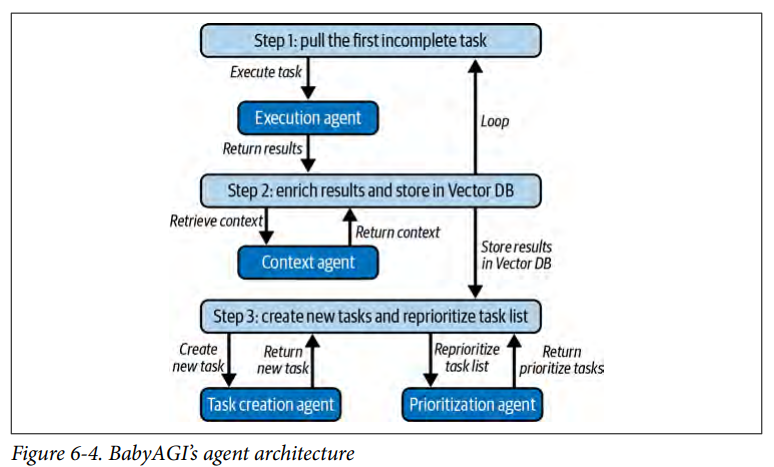


- BabyAGI’s agent setup, which is designed to merge OpenAI LLMs with vector databases such as Chroma/Weaviate to create a robust, adaptive task management system.
- In a continuous loop, the agent starts by fetching a task and passes it to the execution_agent, which taps into OpenAI to perform the task based on contextual data.
- After this, the outcomes are enriched and archived in Chroma/Weaviate.
  The task_creation_agent then steps in, utilizing OpenAI to discern new tasks from
  the objective and results of the prior task.
- These tasks are presented as a list of dictionaries, giving structure to the resultant tasks.
- The prioritization_agent then interacts with OpenAI to rearrange the task list,
  ensuring alignment with the main objective. The synergy of these agents ensures
  that the system is always evolving, continuously generating and prioritizing tasks in an informed manner.
- Integrating Chroma or Weaviate plays a crucial role by
  offering a reservoir of contextual data, ensuring that tasks are always aligned with
  their predefined goals.


The [plan-and-execute agent](https://github.com/langchain-ai/langchain/blob/master/cookbook/plan_and_execute_agent.ipynb) type does exist within LangChain


#### 2. Tree of Thoughts


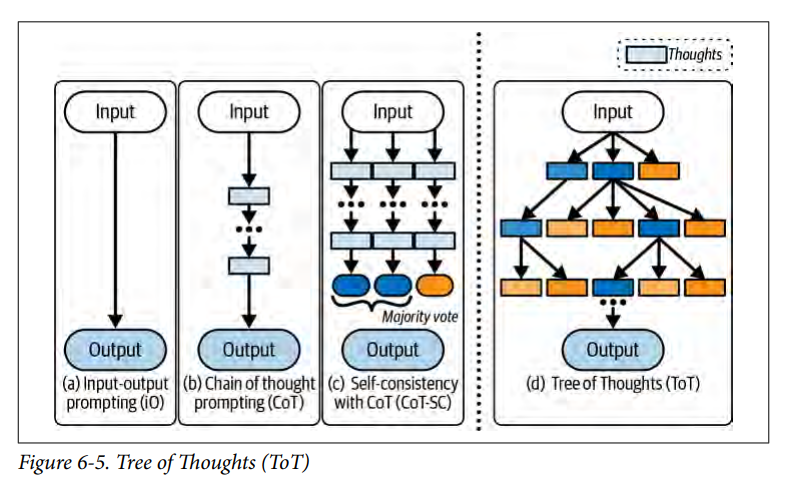


- As the application of language models in problem-solving expands across diverse
  tasks, their inference method remains bound to token-level, linear processing. This
  approach, while effective in many contexts, is limited when faced with tasks that
  need advanced strategic foresight or where the initial decisions are crucial
- The [Tree of Thoughts (ToT)](https://arxiv.org/abs/2305.10601) framework is a novel way to harness language models that goes beyond the conventional chain-of-thought prompting technique

- The central premise of ToT is to enable exploration across coherent text chunks,
  termed thoughts. These thoughts represent stages in problem-solving, facilitating the language model to undertake a more deliberate decision-making process. Instead of sticking to one reasoning path, the model can explore various reasoning trajectories,self-assessing its decisions at each step. The framework is designed to allow for forward planning, revisiting past decisions, and making overarching choices.

- Evidence of its success comes from experimental results on tasks requiring intricate planning or searching capabilities. In a game like game of 24, the traditional GPT-4, when prompted using chain-of-thought, managed a 4% success rate. In contrast, the ToT approach skyrocketed this figure to an impressive 74%. This paradigm shift isn’t limited to games. The ToT method also showed promise in areas like creative writing and mini crosswords, underscoring its versatility.

- Complementing the theory is a [LangChain implementation](https://github.com/langchain-ai/langchain/blob/master/cookbook/tree_of_thought.ipynb), which gives a glimpse into how ToT can be actualized. A sudoku puzzle serves as the illustrative example, with the main aim to replace wildcard characters (\*) with numbers, while adhering to sudoku rules.

- ToT is not just a new method; it’s a paradigm shift in how we envision language
  model inference. By providing models the capacity to think, backtrack, and strategize


# Callbacks


LangChain’s [callbacks](https://python.langchain.com/v0.1/docs/modules/callbacks/) empower you to seamlessly monitor and pinpoint issues within
your application. Until now, you’ve encountered the parameter verbose=True in
AgentExecutor chains:

```python
AgentExecutor(.., verbose=True)
```

- This parameter logs useful outputs for debugging purposes, but what if you’re keen
  on tracking specific events? Enter callbacks, your go-to solution.

- The BaseCallbackHandler class acts as a foundation for monitoring and responding
  to various events during the execution of your generative AI models.

- Each method in this class corresponds to specific stages like the start, end, or even errors during the model’s runtime.

- For instance, the on_llm_start gets triggered when an LLM begins its operation. Similarly, methods like on_chain_error and on_tool_end react to errors in chains or after using a tool:


In [74]:
from typing import Any, Dict
from langchain_core.outputs.llm_result import LLMResult
from langchain_core.messages import BaseMessage


class BaseCallbackHandler:
    """Base callback handler that can be used to handle callbacks from
    langchain."""

    def on_llm_start(
        self, serialized: Dict[str, Any], prompts: List[str],
        **kwargs: Any
    ) -> Any:
        """Run when LLM starts running."""

    def on_chat_model_start(
        self, serialized: Dict[str, Any],
        messages: List[List[BaseMessage]], **kwargs: Any
    ) -> Any:
        """Run when Chat Model starts running."""

    def on_llm_new_token(self, token: str, **kwargs: Any) -> Any:
        """Run on new LLM token. Only available when streaming is enabled."""

    def on_llm_end(self, response: LLMResult, **kwargs: Any) -> Any:
        """Run when LLM ends running."""

    def on_llm_error(
        self, error: Union[Exception, KeyboardInterrupt], **kwargs: Any
    ) -> Any:
        """Run when LLM errors."""

    def on_chain_start(
        self, serialized: Dict[str, Any], inputs: Dict[str, Any],
        **kwargs: Any
    ) -> Any:
        """Run when chain starts running."""

    def on_chain_end(self, outputs: Dict[str, Any], **kwargs: Any) -> Any:
        """Run when chain ends running."""

    def on_chain_error(
        self, error: Union[Exception, KeyboardInterrupt], **kwargs: Any
    ) -> Any:
        """Run when chain errors."""

## Global (Constructor) Callbacks


- When defining callbacks within a constructor, like AgentExecutor(callbacks=[han
  dler], tags=['a-tag']), they are activated for every call made on that instance.
  These callbacks are limited to that specific instance.

- To illustrate, when a handler is passed to an LLMChain during its creation, it won’t interact with any children chains:

- The tags you include, such as 'a-tag', can be tremendously useful in tracing and
  sorting the outputs of your generative AI setup. Especially in large projects with
  numerous chains, utilizing tags can significantly streamline your workflow.


In [75]:
from langchain.agents import AgentExecutor
from langchain.callbacks import StdOutCallbackHandler
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    callbacks=[StdOutCallbackHandler()],
    tags=['a-tag'])
agent_executor.invoke({"input": "How many letters in the word Software?"})



> Entering new AgentExecutor chain...
The word "Software" has 8 letters. Is there anything else you would like to know or discuss, James?

> Finished chain.


{'input': 'How many letters in the word Software?',
 'output': 'The word "Software" has 8 letters. Is there anything else you would like to know or discuss, James?'}

## Request-Specific Callbacks


On the other hand, callbacks can be defined within the invoke() method. For
instance, a request to an LLMChain might subsequently trigger another LLMChain
request, and the same handler would be applied:


In [78]:
from langchain.callbacks import StdOutCallbackHandler
from langchain.chains import LLMChain
from langchain_openai import OpenAI
from langchain_core.prompts import PromptTemplate
handler = StdOutCallbackHandler()
llm = OpenAI()
prompt = PromptTemplate.from_template("What is 1 + {number} = ")
chain = LLMChain(llm=llm, prompt=prompt)
chain.invoke({"number": 2}, {"callbacks": [handler]})



> Entering new LLMChain chain...
Prompt after formatting:
What is 1 + 2 = 

> Finished chain.


{'number': 2, 'text': '3'}

## The Verbose Argument


A common utility, the verbose argument, is accessible for most API objects. When
you use AgentExecutor(verbose=True), it’s the same as integrating a ConsoleCall
backHandler into the callbacks argument of the object and its descendants. It acts as a
useful debugging tool by logging every event directly to your console.


When to Use Which?

1. Constructor callbacks

- Ideal for overarching tasks like logging or monitoring across an entire chain. If
  tracking all interactions within agents is your goal, attach the handler during its
  initiation.

2. Request callbacks

- Tailored for specific use cases like streaming, where outputs from a single request
  are relayed to dedicated endpoints, say a websocket. So, for a scenario where the
  output from a singular request needs to be streamed to a websocket, the handler
  should be linked to the invoke() method.

3. Verbose arguments

- Useful for debugging and local LLM development, but it can generate a large
  number of logs.


## Token Counting with LangChain


In [79]:
import asyncio
from langchain.callbacks import get_openai_callback
from langchain_core.messages import SystemMessage
from langchain_openai.chat_models import ChatOpenAI
model = ChatOpenAI()

In [81]:
with get_openai_callback() as cb:
    model.invoke([SystemMessage(content="My name is Fu Lim")])
total_tokens = cb.total_tokens
print(total_tokens)
assert total_tokens > 0

23


In [83]:
with get_openai_callback() as cb:
    model.invoke([SystemMessage(content="My name is Fu Lim")])
    model.invoke([SystemMessage(content="My name is Fu Lim")])
assert cb.total_tokens > 0
print(cb.total_tokens)

46


In [84]:
# Async callbacks:
with get_openai_callback() as cb:
    await asyncio.gather(
        model.agenerate(
            [
                [SystemMessage(content="Is the meaning of life 42?")],
                [SystemMessage(content="Is the meaning of life 42?")],
            ],
        )
    )
print(cb.__dict__)

{'_lock': <unlocked _thread.lock object at 0x7f8c80c610c0>, 'total_cost': 0.000408, 'total_tokens': 292, 'prompt_tokens': 30, 'completion_tokens': 262, 'successful_requests': 2}


cb provides a detailed breakdown of your interaction with the AI model, offering key
metrics that are pivotal for prompt engineering:

- cb.successful_requests tracks the number of requests that have been executed
  successfully. It’s a direct indicator of how many API requests were effectively
  processed without encountering errors.
- With cb.total_cost, you get a transparent view of the cost associated with your
  requests. This can be a crucial metric for budgeting and managing expenses
  when working extensively with the AI.
- cb.total_tokens denotes the cumulative number of tokens used in both the
  prompt and the completion. This provides a holistic view of token consumption.
- cb.prompt_tokens gives insight into how many tokens were used in the prompts
  you provided. This can guide you in optimizing your prompts to be concise yet
  effective.
- cb.completion_tokens highlights the number of tokens taken up by the AI’s
  response. This can be beneficial when analyzing the verbosity or depth of the AI’s
  answers.
